Single spillover (non-recurrent) branching process (infinite population), plots beta, gamma, and number infected over time.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#class representing one simulation.

class Sim:
    def __init__(self, times, betas, gammas, I, outcome=None):
        
        #0 if extinction, 1 if outbreak, None otherwise
        self.outcome = outcome 
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        
    def append(self, t, beta, gamma, I):
        self.times.append(t)
        self.betas.append(beta)
        self.gammas.append(gamma)
        self.I.append(I)
        
    def set_outcome(self, outcome):
        self.outcome = outcome

In [29]:
#############################################################
# version of sim which 
#    1. is implemented in "time order" instead of "generation order"
#        (this makes it slower to run, but it's needed in order to make accurate plots)
#    2. returns an element of the class Sim.
#############################################################

def sim_class(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t=0
    
    #initialize return object
    sim = Sim([t], [beta_0], [gamma_0], [1])
    
    I = 1 #initialize variable to keep track of total number of infected
        
    #initialize running sums over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 3.
    # each row looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of beta and gamma over all infected people
        overall_rate = beta_sum + gamma_sum
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #figure out who the event happened to
        i = np.random.choice(I, p=(betas+gammas)/overall_rate) #index of that person
        
        #grab their specific beta and gamma
        beta = betas[i]; gamma = gammas[i]
        
        #figure out what they did, transmit or recover. 
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma) #probability of transmission

        if (ev < prob_trans): #transmission

            #pick beta and gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta, gamma
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_gamma = max(0, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)
            
            #update running sums
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update I
            I += 1
            
            #update return object
            sim.append(t, new_beta, new_gamma, I)

            #check if we have an outbreak
            if I >= outbreak_thresh: 
                sim.set_outcome(1)
                return sim

        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update running sums
            beta_sum -= betas[i]; gamma_sum -= gammas[i]
            
            #update I
            I -= 1
            
            #update return object
            sim.append(t, None, None, I)

            #check if we have extinction       
            if I == 0:
                sim.set_outcome(0)
                return sim

In [30]:
%%time 

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu = 0.001

mu_1 = mu
mu_2 = mu

#compute simulation
s = None
while True:
    s = sim_class(beta_0, gamma_0, mu_1, mu_2)
    #if s.outcome == 1: break #get an outbreak
    if s.times[-1] > 50: break #get a simulation where the disease spreads for at least this many days

CPU times: user 51.6 ms, sys: 11.1 ms, total: 62.7 ms
Wall time: 54.8 ms


In [31]:
%%time 

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu = 0.001

mu_1 = mu
mu_2 = mu

#compute simulation
s = None
while True:
    s = sim_class(beta_0, gamma_0, mu_1, mu_2)
    if s.outcome == 1: break #get an outbreak
    #if s.times[-1] > 100: break #get a simulation where the disease spreads for at least this many days
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I

CPU times: user 455 ms, sys: 8.83 ms, total: 464 ms
Wall time: 463 ms


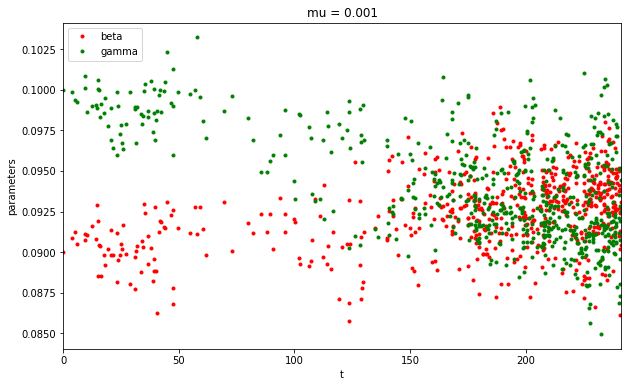

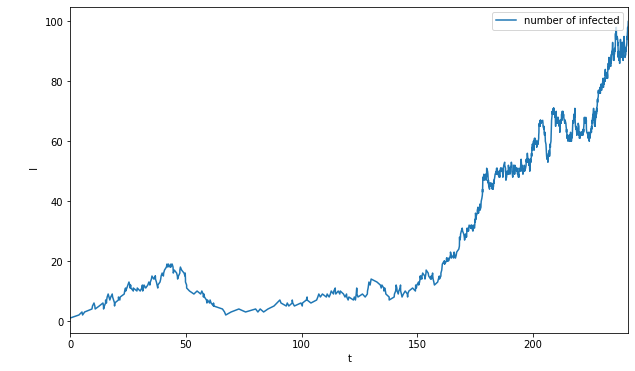

In [32]:
#plots

#plot betas and gammas over time
plt.figure(figsize=(10,6))
plt.plot(times, betas, ".r", label='beta')
plt.plot(times, gammas, ".g", label='gamma')
plt.title('mu = {}'.format(mu))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper left")
plt.show()

#plot I over time
plt.figure(figsize=(10,6))
plt.plot(times, I, label='number of infected')
plt.xlabel("t"); plt.ylabel("\n \n I")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right")
plt.show()

In [227]:
import pickle

In [228]:
#save interesting simulations

#1200 (ish) days simulation with mu = 0.001, beta = 0.09, gamma = 0.1
#pickled to: s_branch_1200.txt

#describe simulation
#pickled to: 

file = open('file.txt', 'wb')
pickle.dump(s, file)
file.close()

In [234]:
#open a pickled simulation

file = open('s_branch_1200.txt', 'rb')
pickled_s = pickle.load(file)
file.close()